# Sentiment Analysis of Hausa, Igbo, and Yoruba Languages

In [1]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\HP\\anaconda3\\Lib\\site-packages\\~ensorflow\\compiler\\mlir\\quantization\\tensorflow\\python\\pywrap_quantize_model.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re


import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


In [3]:
# Loading the datasets, stopwords, and lexicons
languages = ['hausa', 'igbo', 'yoruba']
train_data = {}
dev_data = {}
test_data = {}
stopwords = {}
lexicons = {}

for lang in languages:
    train_data[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_train.tsv', delimiter='\t')
    dev_data[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_dev.tsv', delimiter='\t')
    test_data[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_test.tsv', delimiter='\t')
    stopwords[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_stopwords.csv')
    lexicons[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_lexicon.csv')

In [4]:
# Print the first 5 rows of the hausa train data, yoruba train data, and igbo train data and their shapes
print('Hausa Train Data')
print(train_data['hausa'].head())
print(train_data['hausa'].shape)
print('\n')
print('Igbo Train Data')
print(train_data['igbo'].head())
print(train_data['igbo'].shape)
print('\n')
print('Yoruba Train Data')
print(train_data['yoruba'].head())
print(train_data['yoruba'].shape)
print('\n')

Hausa Train Data
                                               tweet     label
0  @user Da kudin da Arewa babu wani abin azo aga...  negative
1  @user Kaga wani Adu ar Banda💔😭 wai a haka Shi ...  negative
2  @user Sai haquri fa yan madrid daman kunce cha...  negative
3  @user Hmmm yanzu kai kasan girman allah daxaka...  negative
4  @user @user Wai gwamno nin Nigeria suna afa kw...  negative
(14172, 2)


Igbo Train Data
                                               tweet     label
0       Nna Ike Gwuru ooo. 😂 https://t.co/NDS7juFBGd  negative
1                 @user Chineke nna kezi mgbe ole???  negative
2  Lol. Isi adirokwanu gi nma.. 😐😒😒😒 https://t.co...  negative
3  @user haha. Fulani herdsmen. akpa amu gi retwe...  negative
4  Nna ghetto di gi na aru biko!!! https://t.co/4...  negative
(10192, 2)


Yoruba Train Data
                                               tweet     label
0  Ìwọ ikú òpònú abaradúdú wọ, o ò ṣe é 're o. O ...  negative
1  Yorùbá nbú'yàn ṣá """"""""..àyà wanle 

# DATA PREPROCESSING

In [5]:
# create a function to clean the text data
def clean_text_data(data):
    if 'text' in data.columns:
        data['text'] = data['text'].apply(clean_text)
    return data
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removing @mentions
    text = re.sub(r'#', '', text) # Removing '#' hash tag
    text = re.sub(r'RT[\s]+', '', text) # Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) # Removing the hyper link
    text = re.sub(r'[^\w\s]', '', text) # Removing the punctuation
    text = re.sub(r'\d+', '', text) # Removing the digits
    text = text.lower() # Converting the text to lower case
    return text

#  apply the clean_text function to the text data
for lang in languages:
    train_data[lang]['tweet'] = train_data[lang]['tweet'].apply(clean_text)
    dev_data[lang]['tweet'] = dev_data[lang]['tweet'].apply(clean_text)
    test_data[lang]['tweet'] = test_data[lang]['tweet'].apply(clean_text)

In [6]:
# Print the first 5 rows of the hausa train data
print('Hausa Train Data')
print(train_data['hausa'].head())

Hausa Train Data
                                               tweet     label
0   da kudin da arewa babu wani abin azo agani da...  negative
1   kaga wani adu ar banda wai a haka shi ne shug...  negative
2   sai haquri fa yan madrid daman kunce champion...  negative
3   hmmm yanzu kai kasan girman allah daxakace mu...  negative
4        wai gwamno nin nigeria suna afa kwayoyi ko   negative


In [7]:
# Remove the stopwords from the train, test, dev data for the three languages
def remove_stopwords(data, stopwords):
    data['tweet'] = data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

for lang in languages:
    train_data[lang] = remove_stopwords(train_data[lang], stopwords[lang])
    dev_data[lang] = remove_stopwords(dev_data[lang], stopwords[lang])
    test_data[lang] = remove_stopwords(test_data[lang], stopwords[lang])

# Print the first 5 rows of the hausa train data
print('Yoruba Train Data')
print(train_data['hausa'].head())



Yoruba Train Data
                                               tweet     label
0  da kudin da arewa babu wani abin azo agani da ...  negative
1  kaga wani adu ar banda wai a haka shi ne shuga...  negative
2  sai haquri fa yan madrid daman kunce champion ...  negative
3  hmmm yanzu kai kasan girman allah daxakace muk...  negative
4         wai gwamno nin nigeria suna afa kwayoyi ko  negative


In [8]:
# Create a function to calculate the sentiment score
def calculate_sentiment_score(text, lexicon_dict):
    score = 0
    words = text.split()
    for word in words:
        score += lexicon_dict.get(word, 0)
    return score

def process_data(df, lexicon):
    lexicon_dict = lexicon.set_index('human')['label'].map({'positive': 1, 'negative': -1}).to_dict()
    df["sentiment_score"] = df["tweet"].apply(calculate_sentiment_score, args=(lexicon_dict,))
    return df

In [9]:
# Apply the process_data function to the train, test, dev data for the three languages   
for lang in languages:
    train_data[lang] = process_data(train_data[lang], lexicons[lang])
    dev_data[lang] = process_data(dev_data[lang], lexicons[lang])
    test_data[lang] = process_data(test_data[lang], lexicons[lang])

In [10]:
# print the first 5 rows of the hausa train data
print('Hausa Train Data')
train_data['hausa'].head()

Hausa Train Data


,tweet,label,sentiment_score
0,da kudin da arewa babu wani abin azo agani da ...,negative,-1
1,kaga wani adu ar banda wai a haka shi ne shuga...,negative,1
2,sai haquri fa yan madrid daman kunce champion ...,negative,1
3,hmmm yanzu kai kasan girman allah daxakace muk...,negative,-5
4,wai gwamno nin nigeria suna afa kwayoyi ko,negative,-1


In [11]:
# Perfrom label encoding on the label column
le = preprocessing.LabelEncoder()
for lang in languages:
    train_data[lang]['label'] = le.fit_transform(train_data[lang]['label'])
    dev_data[lang]['label'] = le.transform(dev_data[lang]['label'])
    test_data[lang]['label'] = le.transform(test_data[lang]['label'])



In [12]:
# print the first 5 rows of the hausa train data
print('Hausa Train Data')
train_data['hausa'].head()

Hausa Train Data


,tweet,label,sentiment_score
0,da kudin da arewa babu wani abin azo agani da ...,0,-1
1,kaga wani adu ar banda wai a haka shi ne shuga...,0,1
2,sai haquri fa yan madrid daman kunce champion ...,0,1
3,hmmm yanzu kai kasan girman allah daxakace muk...,0,-5
4,wai gwamno nin nigeria suna afa kwayoyi ko,0,-1


In [13]:
# %pip install nltk
# import nltk
# nltk.download('punkt')

# def tokenize_text(text):
#     return nltk.word_tokenize(text)

# # Apply the tokenize_text function to the train, test, dev data for the three languages
# for lang in languages:
#     train_data[lang]['tweet'] = train_data[lang]['tweet'].apply(tokenize_text)
#     dev_data[lang]['tweet'] = dev_data[lang]['tweet'].apply(tokenize_text)
#     test_data[lang]['tweet'] = test_data[lang]['tweet'].apply(tokenize_text)
    
# # print the first 5 rows of the hausa train data
# print('Hausa Train Data')
# train_data['hausa'].head()



In [172]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords[lang]['word'].tolist(), max_df=10, max_features=None)

# Fit and transform the preprocessed text data to obtain BoW features
X_train_bow = {}
X_dev_bow = {}
X_test_bow = {}

for lang in languages:
    X_train_bow[lang] = vectorizer.fit_transform(train_data[lang]['tweet'])
    X_dev_bow[lang] = vectorizer.transform(dev_data[lang]['tweet'])
    X_test_bow[lang] = vectorizer.transform(test_data[lang]['tweet'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_bow for {lang}:", X_train_bow[lang].shape)
    print(f"Shape of X_dev_bow for {lang}:", X_dev_bow[lang].shape)
    print(f"Shape of X_test_bow for {lang}:", X_test_bow[lang].shape)

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fẹ', 'jẹ', 'rẹ', 'rọ', 'wọ'] not in stop_words.
  warnings.warn(


Shape of X_train_bow for hausa: (14172, 20009)
Shape of X_dev_bow for hausa: (2677, 20009)
Shape of X_test_bow for hausa: (5303, 20009)
Shape of X_train_bow for igbo: (10192, 14469)
Shape of X_dev_bow for igbo: (1841, 14469)
Shape of X_test_bow for igbo: (3682, 14469)
Shape of X_train_bow for yoruba: (8522, 20768)
Shape of X_dev_bow for yoruba: (2090, 20768)
Shape of X_test_bow for yoruba: (4515, 20768)


In [14]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text data to obtain tf-idf features
X_train_tfidf = {}
X_dev_tfidf = {}
X_test_tfidf = {}

for lang in languages:
    X_train_tfidf[lang] = tfidf_vectorizer.fit_transform(train_data[lang]['tweet'])
    X_dev_tfidf[lang] = tfidf_vectorizer.transform(dev_data[lang]['tweet'])
    X_test_tfidf[lang] = tfidf_vectorizer.transform(test_data[lang]['tweet'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_tfidf for {lang}:", X_train_tfidf[lang].shape)
    print(f"Shape of X_dev_tfidf for {lang}:", X_dev_tfidf[lang].shape)
    print(f"Shape of X_test_tfidf for {lang}:", X_test_tfidf[lang].shape)

Shape of X_train_tfidf for hausa: (14172, 21786)
Shape of X_dev_tfidf for hausa: (2677, 21786)
Shape of X_test_tfidf for hausa: (5303, 21786)
Shape of X_train_tfidf for igbo: (10192, 15502)
Shape of X_dev_tfidf for igbo: (1841, 15502)
Shape of X_test_tfidf for igbo: (3682, 15502)
Shape of X_train_tfidf for yoruba: (8522, 22316)
Shape of X_dev_tfidf for yoruba: (2090, 22316)
Shape of X_test_tfidf for yoruba: (4515, 22316)


In [15]:
# Create a function to train a logistic regression model with the given feature matrix and labels
def train_logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    return model

# Create a function to train a naive bayes model with the given feature matrix and labels
def train_naive_bayes(X, y):
    model = MultinomialNB()
    model.fit(X, y)
    return model

# Create a function to train a support vector machine model with the given feature matrix and labels
def train_svm(X, y):
    model = SVC()
    model.fit(X, y)
    return model

# Create a function to make predictions using the given model and feature matrix
def predict(model, X):
    return model.predict(X)

# Create a function to evaluate the given model using the given feature matrix and labels
def evaluate_model(model, X, y):
    y_pred = predict(model, X)
    return accuracy_score(y, y_pred)   

In [16]:
# Train logistic regression models using the tf-idf feature matrices for the three languages
logistic_regression_models = {}
for lang in languages:
    logistic_regression_models[lang] = train_logistic_regression(X_train_tfidf[lang], train_data[lang]['label'])
    
# Evaluate the logistic regression models using the dev data
logistic_regression_scores = {}
for lang in languages:
    logistic_regression_scores[lang] = evaluate_model(logistic_regression_models[lang], X_dev_tfidf[lang], dev_data[lang]['label'])
    print(f"Accuracy of logistic regression model for {lang}:", logistic_regression_scores[lang])

# Train naive bayes models using the tf-idf feature matrices for the three languages
naive_bayes_models = {}
for lang in languages:
    naive_bayes_models[lang] = train_naive_bayes(X_train_tfidf[lang], train_data[lang]['label'])

# Evaluate the naive bayes models using the dev data
naive_bayes_scores = {}
for lang in languages:
    naive_bayes_scores[lang] = evaluate_model(naive_bayes_models[lang], X_dev_tfidf[lang], dev_data[lang]['label'])
    print(f"Accuracy of naive bayes model for {lang}:", naive_bayes_scores[lang])



Accuracy of logistic regression model for hausa: 0.7407545760179305
Accuracy of logistic regression model for igbo: 0.7767517653449212
Accuracy of logistic regression model for yoruba: 0.7282296650717703
Accuracy of naive bayes model for hausa: 0.711243929772133
Accuracy of naive bayes model for igbo: 0.7278652906029331
Accuracy of naive bayes model for yoruba: 0.6588516746411484


In [17]:
# Test the logistic regression models using the test data and print the classification report
logistic_regression_predictions = {}
for lang in languages:
    logistic_regression_predictions[lang] = predict(logistic_regression_models[lang], X_test_tfidf[lang])
    print(f"Classification report for logistic regression model for {lang}:\n", classification_report(test_data[lang]['label'], logistic_regression_predictions[lang]))

# Test the naive bayes models using the test data and print the classification report
naive_bayes_predictions = {}
for lang in languages:
    naive_bayes_predictions[lang] = predict(naive_bayes_models[lang], X_test_tfidf[lang])
    print(f"Classification report for naive bayes model for {lang}:\n", classification_report(test_data[lang]['label'], naive_bayes_predictions[lang]))
    


Classification report for logistic regression model for hausa:
               precision    recall  f1-score   support

           0       0.73      0.66      0.69      1759
           1       0.66      0.76      0.71      1789
           2       0.85      0.80      0.82      1755

    accuracy                           0.74      5303
   macro avg       0.75      0.74      0.74      5303
weighted avg       0.75      0.74      0.74      5303

Classification report for logistic regression model for igbo:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69       943
           1       0.72      0.88      0.79      1621
           2       0.87      0.76      0.81      1118

    accuracy                           0.78      3682
   macro avg       0.80      0.75      0.77      3682
weighted avg       0.79      0.78      0.77      3682

Classification report for logistic regression model for yoruba:
               precision    recall  f1-score   

In [18]:
#  Create a function to tune the hyperparameters of the logistic regression model
def tune_logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X, y)
    return grid.best_estimator_

# Create a function to tune the hyperparameters of the naive bayes model
def tune_naive_bayes(X, y):
    model = MultinomialNB()
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X, y)
    return grid.best_estimator_

# Tune the hyperparameters of the logistic regression models using the tf-idf feature matrices for the three languages
tuned_logistic_regression_models = {}
for lang in languages:
    tuned_logistic_regression_models[lang] = tune_logistic_regression(X_train_tfidf[lang], train_data[lang]['label'])
    
# Evaluate the tuned logistic regression models using the dev data
tuned_logistic_regression_scores = {}
for lang in languages:
    tuned_logistic_regression_scores[lang] = evaluate_model(tuned_logistic_regression_models[lang], X_dev_tfidf[lang], dev_data[lang]['label'])
    print(f"Accuracy of tuned logistic regression model for {lang}:", tuned_logistic_regression_scores[lang])

# Tune the hyperparameters of the naive bayes models using the tf-idf feature matrices for the three languages
tuned_naive_bayes_models = {}
for lang in languages:
    tuned_naive_bayes_models[lang] = tune_naive_bayes(X_train_tfidf[lang], train_data[lang]['label'])
    
# Print the best hyperparameters for the tuned Logistic Regression and naive bayes models
for lang in languages:
    print(f"Best hyperparameters for tuned logistic regression model for {lang}:", tuned_logistic_regression_models[lang])
    print(f"Best hyperparameters for tuned naive bayes model for {lang}:", tuned_naive_bayes_models[lang])
    


Accuracy of tuned logistic regression model for hausa: 0.7381397086290624
Accuracy of tuned logistic regression model for igbo: 0.779467680608365
Accuracy of tuned logistic regression model for yoruba: 0.7416267942583732
Best hyperparameters for tuned logistic regression model for hausa: LogisticRegression(C=10, max_iter=1000)
Best hyperparameters for tuned naive bayes model for hausa: MultinomialNB(alpha=1)
Best hyperparameters for tuned logistic regression model for igbo: LogisticRegression(C=10, max_iter=1000)
Best hyperparameters for tuned naive bayes model for igbo: MultinomialNB(alpha=0.1)
Best hyperparameters for tuned logistic regression model for yoruba: LogisticRegression(C=10, max_iter=1000)
Best hyperparameters for tuned naive bayes model for yoruba: MultinomialNB(alpha=0.1)


In [19]:
# Test the tuned logistic regression models using the test data and print the classification report
tuned_logistic_regression_predictions = {}
for lang in languages:
    tuned_logistic_regression_predictions[lang] = predict(tuned_logistic_regression_models[lang], X_test_tfidf[lang])
    print(f"Classification report for tuned logistic regression model for {lang}:\n", classification_report(test_data[lang]['label'], tuned_logistic_regression_predictions[lang]))
    
# Test the tuned naive bayes models using the test data and print the classification report
tuned_naive_bayes_predictions = {}
for lang in languages:
    tuned_naive_bayes_predictions[lang] = predict(tuned_naive_bayes_models[lang], X_test_tfidf[lang])
    print(f"Classification report for tuned naive bayes model for {lang}:\n", classification_report(test_data[lang]['label'], tuned_naive_bayes_predictions[lang]))

Classification report for tuned logistic regression model for hausa:
               precision    recall  f1-score   support

           0       0.73      0.68      0.71      1759
           1       0.68      0.74      0.71      1789
           2       0.83      0.81      0.82      1755

    accuracy                           0.75      5303
   macro avg       0.75      0.75      0.75      5303
weighted avg       0.75      0.75      0.75      5303

Classification report for tuned logistic regression model for igbo:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71       943
           1       0.75      0.82      0.78      1621
           2       0.83      0.78      0.80      1118

    accuracy                           0.77      3682
   macro avg       0.77      0.76      0.77      3682
weighted avg       0.77      0.77      0.77      3682

Classification report for tuned logistic regression model for yoruba:
               precision    r

In [23]:

for lang in languages:
    correct_predictions = test_data[lang][test_data[lang]['label'] == tuned_logistic_regression_predictions[lang]].sample(5)
    incorrect_predictions = test_data[lang][test_data[lang]['label'] != tuned_logistic_regression_predictions[lang]].sample(5)
    
    print(f"Sample correct predictions for {lang}:")
    display(pd.DataFrame({'Tweet': correct_predictions['tweet'], 'Actual': correct_predictions['label'], 'Predicted': tuned_logistic_regression_predictions[lang][correct_predictions.index]}))
    
    print(f"Sample incorrect predictions for {lang}:")
    display(pd.DataFrame({'Tweet': incorrect_predictions['tweet'], 'Actual': incorrect_predictions['label'], 'Predicted': tuned_logistic_regression_predictions[lang][incorrect_predictions.index]}))

for lang in languages:
    correct_predictions = test_data[lang][test_data[lang]['label'] == tuned_naive_bayes_predictions[lang]].sample(5)
    incorrect_predictions = test_data[lang][test_data[lang]['label'] != tuned_naive_bayes_predictions[lang]].sample(5)
    
    print(f"Sample correct predictions for {lang}:")
    display(pd.DataFrame({'Tweet': correct_predictions['tweet'], 'Actual': correct_predictions['label'], 'Predicted': tuned_naive_bayes_predictions[lang][correct_predictions.index]}))
    
    print(f"Sample incorrect predictions for {lang}:")
    display(pd.DataFrame({'Tweet': incorrect_predictions['tweet'], 'Actual': incorrect_predictions['label'], 'Predicted': tuned_naive_bayes_predictions[lang][incorrect_predictions.index]}))

Sample correct predictions for hausa:


,Tweet,Actual,Predicted
1682,nidai abinda yake burgeni dake rahama tunda ki...,2,2
1610,allah ke nnin bai baka wannan ba sai ya baka w...,2,2
3472,malam falalu amman da kai da yaya dan kwanbo k...,1,1
4200,gskya dan iska neh,0,0
3245,todama wane ubane zaitonawa yayansa asiri me b...,1,1


Sample incorrect predictions for hausa:


,Tweet,Actual,Predicted
4285,gaskiyan magana shine matannan abun nata ya fa...,0,1
4710,tohh yanzu ita wannan din mai ķwadayi ce ko ma...,0,1
1240,ydg nidai wannan tambayar ku na yau yafi karfi...,2,1
4994,madallah dama iskanchin da akeyi a onitsha ya ...,0,1
4831,yayi kacakaca da su,0,1


Sample correct predictions for igbo:


,Tweet,Actual,Predicted
2531,odogwu na ọkụ nọ ọkụ ka ana àlà ònye ekpenta m...,1,1
1027,ebube umu igbo ji aga karịrị,2,2
2927,ekwensu ifele megbuo gị smh,0,0
666,with kpo di kpo liveradioparty,2,2
880,ibu chukwu onye dimma ibu chukwu onye di ike i...,2,2


Sample incorrect predictions for igbo:


,Tweet,Actual,Predicted
3037,oga ese kwa okwu biko,0,1
856,boss biko blessia nwanne gi biko nu gtb,2,1
945,onye eh onye eh onye eh odighi onye di ka gi,2,0
892,amara m na onye nche m no nso amara m na o rap...,2,1
2950,akuko nya ndi abroad putaba isolukwuo puta ife...,0,1


Sample correct predictions for yoruba:


,Tweet,Actual,Predicted
155,eto naa lo sepesepee se te ranti wa báwo ni gb...,2,2
2029,fífi àlejò sí ìyára tàbí ibi tí yóò forí lélẹ ...,1,1
1650,ó di mẹta mo kí nwokorie kú iṣẹ,2,2
3004,awon kan npe nii aganrandi,1,1
3403,ìgbà ò lọ bí òréré,1,1


Sample incorrect predictions for yoruba:


,Tweet,Actual,Predicted
2977,ṣe àlàyé òwe yìí à ti gbé yàwó kò tóó pọn owó ...,1,0
2014,ìkíni ní ilẹ yorùbá sí ẹni tí ń ṣe àárẹ ẹ pẹlẹ...,1,2
3182,ẹni a fẹ la mọ a ò mẹni tó fẹni ẹni ìjà kò bá ...,1,0
2615,ninu ohun elo yi ni a ko awon ibere idanwo wae...,1,0
4411,ilu ibadan lale hmmm o ga o,0,1


Sample correct predictions for hausa:


,Tweet,Actual,Predicted
1622,allah ya maimai ta mana hakan sau dubu,2,2
4909,muma muna allah wadai da kisan da takewa mutan...,0,0
4884,kai rahama sadau tasan cewa duniya budurwar wa...,0,0
3096,tabb dama kina zuwa skul amaji nawa kike,1,1
713,alhamdulillah yakara tattalin arzikin,2,2


Sample incorrect predictions for hausa:


,Tweet,Actual,Predicted
149,sarkin kano ma yayi hudubar akan dadin mulki,2,0
5129,yawalw mayen jirgi na aisha mai duwawun 𝖉ani a...,0,2
1832,anya babu lauje cikin nadi kuwa,1,0
1558,yanzu an gama da corona a kaduna kenan,2,1
2694,kuce wa mutanen dasuka daukeshi muna bukatarsu...,1,0


Sample correct predictions for igbo:


,Tweet,Actual,Predicted
2771,onye amuma ugha,0,0
1057,ibu chimo ibu chimo ibu chimo onye nji eme onu,2,2
3586,nsogbu di o,0,0
2285,talking about igbo leaders i dont think is amo...,1,1
2724,màkà chi ọkwa nwanne dị na mba,1,1


Sample incorrect predictions for igbo:


,Tweet,Actual,Predicted
2326,a nyuchaa nsị a tupiaghi ya ọnụ ọ bụrụ otolo,1,0
2651,mana ọ dị possible na ọtụrụkpọkpọ naasi asị et...,1,0
491,odogwu lawyer nsogbu adi ro,2,1
1948,onwere ihe m choro ikpuru gi nime govt house a...,1,0
2747,aaaayyiiii obi adikwagha gi mma ooo gini ka an...,0,1


Sample correct predictions for yoruba:


,Tweet,Actual,Predicted
2526,ta ló rí gẹlẹdẹ àti nǹkan mìíìn tó jẹ ti,1,1
2453,ó di ọjọ kẹta oṣù òkúdù kí a tó mú ọdún tuntun...,1,1
1919,ní èèbó thomas harding rí eré orí mẹta èyí tí ...,1,1
2705,àààlò o òjò patapàtà ó dórí àpáta ó rá kí ni o...,1,1
3992,iléiṣẹ nepa ń wí àwáwí ó ní afẹfẹìdáná tó hán ...,0,0


Sample incorrect predictions for yoruba:


,Tweet,Actual,Predicted
1681,ní àárín àwọn yorùbá ìyẹn ní ayée nàmínnalẹ àw...,2,1
2345,ni odun ni ileise telefisan cnn bosi ori ero a...,1,2
46,ṣé ò ń ṣe ẹtọ ẹ gẹgẹ bíi baba,2,1
2954,ìròyìn ojúmilóṣe òwe àjùmọbí ò kan tàánú ẹni o...,1,2
3889,ẹni tí a ó fẹ nílé ẹ ń jìnà,0,2


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Create a function to train a Random Forest model with the given feature matrix and labels
def train_random_forest(X, y):
    model = RandomForestClassifier()
    model.fit(X, y)
    return model

# Train Random Forest models using the tf-idf feature matrices for the three languages
random_forest_models = {}
for lang in languages:
    random_forest_models[lang] = train_random_forest(X_train_tfidf[lang], train_data[lang]['label'])

# Test the Random Forest models using the dev data and print the classification report
random_forest_predictions = {}
for lang in languages:
    random_forest_predictions[lang] = predict(random_forest_models[lang], X_dev_tfidf[lang])
    print(f"Classification report for Random Forest model for {lang}:\n", classification_report(dev_data[lang]['label'], random_forest_predictions[lang]))

Classification report for Random Forest model for hausa:
               precision    recall  f1-score   support

           0       0.75      0.57      0.65       894
           1       0.62      0.80      0.70       896
           2       0.85      0.79      0.82       887

    accuracy                           0.72      2677
   macro avg       0.74      0.72      0.72      2677
weighted avg       0.74      0.72      0.72      2677

Classification report for Random Forest model for igbo:
               precision    recall  f1-score   support

           0       0.76      0.61      0.68       470
           1       0.71      0.85      0.77       811
           2       0.85      0.75      0.80       560

    accuracy                           0.76      1841
   macro avg       0.77      0.74      0.75      1841
weighted avg       0.77      0.76      0.76      1841

Classification report for Random Forest model for yoruba:
               precision    recall  f1-score   support

         

In [60]:
# Evaluate the Random Forest models using the test data

random_forest_scores = {}
for lang in languages:
    random_forest_scores[lang] = evaluate_model(random_forest_models[lang], X_test_tfidf[lang], test_data[lang]['label'])
    print(f"Accuracy of Random Forest model for {lang}:", random_forest_scores[lang])


Accuracy of Random Forest model for hausa: 0.7154440882519328
Accuracy of Random Forest model for igbo: 0.762900597501358
Accuracy of Random Forest model for yoruba: 0.6863787375415282


In [87]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.003)

# Create a function to train a multi layer LSTM model
def train_lstm(X, y, max_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(X, y, epochs=5, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    return model

# Tokenize the text
max_features = 15000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data[lang]['tweet'])

# Train multi layer LSTM models using the tokenized text for the three languages
lstm_models = {}
max_len = 70
for lang in languages:
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_data[lang]['tweet']), maxlen=max_len)
    y_train_seq = pd.get_dummies(train_data[lang]['label']).values
    vocab_size = len(tokenizer.word_index) + 1
    lstm_models[lang] = train_lstm(X_train_seq, y_train_seq, max_len, vocab_size)
    
# Evaluate the LSTM models using the dev data
lstm_scores = {}
for lang in languages:
    X_dev_seq = pad_sequences(tokenizer.texts_to_sequences(dev_data[lang]['tweet']), maxlen=max_len)
    y_dev_seq = pd.get_dummies(dev_data[lang]['label']).values
    lstm_scores[lang] = lstm_models[lang].evaluate(X_dev_seq, y_dev_seq, verbose=0)[1]
    print(f"Accuracy of LSTM model for {lang}:", lstm_scores[lang])

Epoch 1/5
200/200 [==============================] - 115s 542ms/step - loss: 0.8889 - accuracy: 0.5637 - val_loss: 0.9154 - val_accuracy: 0.6199
Epoch 2/5
200/200 [==============================] - 120s 599ms/step - loss: 0.8152 - accuracy: 0.6139 - val_loss: 0.9895 - val_accuracy: 0.5959
Epoch 3/5
200/200 [==============================] - 119s 593ms/step - loss: 0.7830 - accuracy: 0.6317 - val_loss: 0.8713 - val_accuracy: 0.6305
Epoch 4/5
200/200 [==============================] - 118s 593ms/step - loss: 0.7610 - accuracy: 0.6481 - val_loss: 0.9902 - val_accuracy: 0.6291
Epoch 5/5
200/200 [==============================] - 106s 531ms/step - loss: 0.7414 - accuracy: 0.6570 - val_loss: 0.9287 - val_accuracy: 0.6319
Epoch 1/5
144/144 [==============================] - 90s 589ms/step - loss: 0.8819 - accuracy: 0.6000 - val_loss: 1.1145 - val_accuracy: 0.4216
Epoch 2/5
144/144 [==============================] - 88s 609ms/step - loss: 0.7609 - accuracy: 0.6595 - val_loss: 1.1225 - val_accu

In [88]:
# Test the LSTM models using the test data and print the classification report
lstm_predictions = {}
for lang in languages:
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_data[lang]['tweet']), maxlen=max_len)
    y_test_seq = pd.get_dummies(test_data[lang]['label']).values
    lstm_predictions[lang] = np.argmax(lstm_models[lang].predict(X_test_seq), axis=-1)
    print(f"Classification report for LSTM model for {lang}:\n", classification_report(np.argmax(y_test_seq, axis=-1), lstm_predictions[lang]))
    

166/166 [==============================] - 11s 62ms/step
Classification report for LSTM model for hausa:
               precision    recall  f1-score   support

           0       0.53      0.50      0.52      1759
           1       0.52      0.64      0.57      1789
           2       0.79      0.65      0.72      1755

    accuracy                           0.60      5303
   macro avg       0.61      0.60      0.60      5303
weighted avg       0.61      0.60      0.60      5303

116/116 [==============================] - 7s 61ms/step
Classification report for LSTM model for igbo:
               precision    recall  f1-score   support

           0       0.50      0.53      0.51       943
           1       0.59      0.72      0.65      1621
           2       0.71      0.43      0.54      1118

    accuracy                           0.59      3682
   macro avg       0.60      0.56      0.57      3682
weighted avg       0.60      0.59      0.58      3682

142/142 [===================

In [95]:
from keras.layers import Bidirectional

optimizer = Adam(learning_rate=0.0005)

def train_bilstm(X, y, max_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(75, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(X, y, epochs=5, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    return model

# Tokenize the text
max_features = 22000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data[lang]['tweet'])

# Train multi layer LSTM models using the tokenized text for the three languages
lstm_models = {}
max_len = 70
for lang in languages:
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_data[lang]['tweet']), maxlen=max_len)
    y_train_seq = pd.get_dummies(train_data[lang]['label']).values
    vocab_size = len(tokenizer.word_index) + 1
    lstm_models[lang] = train_bilstm(X_train_seq, y_train_seq, max_len, vocab_size)
    
# Evaluate the LSTM models using the dev data
lstm_scores = {}
for lang in languages:
    X_dev_seq = pad_sequences(tokenizer.texts_to_sequences(dev_data[lang]['tweet']), maxlen=max_len)
    y_dev_seq = pd.get_dummies(dev_data[lang]['label']).values
    lstm_scores[lang] = lstm_models[lang].evaluate(X_dev_seq, y_dev_seq, verbose=0)[1]
    print(f"Accuracy of Bi-LSTM model for {lang}:", lstm_scores[lang])

Epoch 1/5
200/200 [==============================] - 192s 922ms/step - loss: 0.9704 - accuracy: 0.5003 - val_loss: 0.9971 - val_accuracy: 0.6079
Epoch 2/5
200/200 [==============================] - 199s 994ms/step - loss: 0.8431 - accuracy: 0.5900 - val_loss: 0.8616 - val_accuracy: 0.6467
Epoch 3/5
200/200 [==============================] - 225s 1s/step - loss: 0.8069 - accuracy: 0.6149 - val_loss: 0.8400 - val_accuracy: 0.6559
Epoch 4/5
200/200 [==============================] - 211s 1s/step - loss: 0.7847 - accuracy: 0.6341 - val_loss: 0.8595 - val_accuracy: 0.6608
Epoch 5/5
200/200 [==============================] - 223s 1s/step - loss: 0.7661 - accuracy: 0.6454 - val_loss: 0.7747 - val_accuracy: 0.6834
Epoch 1/5
144/144 [==============================] - 170s 1s/step - loss: 0.9177 - accuracy: 0.5748 - val_loss: 1.1280 - val_accuracy: 0.3853
Epoch 2/5
144/144 [==============================] - 138s 962ms/step - loss: 0.7627 - accuracy: 0.6648 - val_loss: 0.9606 - val_accuracy: 0.50

In [96]:
# Test the LSTM models using the test data and print the classification report
lstm_predictions = {}
for lang in languages:
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_data[lang]['tweet']), maxlen=max_len)
    y_test_seq = pd.get_dummies(test_data[lang]['label']).values
    lstm_predictions[lang] = np.argmax(lstm_models[lang].predict(X_test_seq), axis=-1)
    print(f"Classification report for Bi-LSTM model for {lang}:\n", classification_report(np.argmax(y_test_seq, axis=-1), lstm_predictions[lang]))
    

166/166 [==============================] - 15s 84ms/step
Classification report for Bi-LSTM model for hausa:
               precision    recall  f1-score   support

           0       0.61      0.39      0.47      1759
           1       0.52      0.76      0.62      1789
           2       0.79      0.70      0.74      1755

    accuracy                           0.62      5303
   macro avg       0.64      0.62      0.61      5303
weighted avg       0.64      0.62      0.61      5303

116/116 [==============================] - 10s 72ms/step
Classification report for Bi-LSTM model for igbo:
               precision    recall  f1-score   support

           0       0.52      0.55      0.54       943
           1       0.60      0.75      0.67      1621
           2       0.77      0.47      0.58      1118

    accuracy                           0.61      3682
   macro avg       0.63      0.59      0.60      3682
weighted avg       0.63      0.61      0.61      3682

142/142 [============

In [97]:
train_data['hausa'].head()

,tweet,label,sentiment_score
0,da kudin da arewa babu wani abin azo agani da ...,0,-1
1,kaga wani adu ar banda wai a haka shi ne shuga...,0,1
2,sai haquri fa yan madrid daman kunce champion ...,0,1
3,hmmm yanzu kai kasan girman allah daxakace muk...,0,-5
4,wai gwamno nin nigeria suna afa kwayoyi ko,0,-1


In [207]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords[lang]['word'].tolist(), min_df=10, max_features=1000)

# Fit and transform the preprocessed text data to obtain BoW features
X_train_bow = {}
X_dev_bow = {}
X_test_bow = {}

for lang in languages:
    X_train_bow[lang] = vectorizer.fit_transform(train_data[lang]['tweet'])
    X_dev_bow[lang] = vectorizer.transform(dev_data[lang]['tweet'])
    X_test_bow[lang] = vectorizer.transform(test_data[lang]['tweet'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_bow for {lang}:", X_train_bow[lang].shape)
    print(f"Shape of X_dev_bow for {lang}:", X_dev_bow[lang].shape)
    print(f"Shape of X_test_bow for {lang}:", X_test_bow[lang].shape)

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fẹ', 'jẹ', 'rẹ', 'rọ', 'wọ'] not in stop_words.
  warnings.warn(


Shape of X_train_bow for hausa: (14172, 1000)
Shape of X_dev_bow for hausa: (2677, 1000)
Shape of X_test_bow for hausa: (5303, 1000)
Shape of X_train_bow for igbo: (10192, 1000)
Shape of X_dev_bow for igbo: (1841, 1000)
Shape of X_test_bow for igbo: (3682, 1000)
Shape of X_train_bow for yoruba: (8522, 1000)
Shape of X_dev_bow for yoruba: (2090, 1000)
Shape of X_test_bow for yoruba: (4515, 1000)


In [268]:
def train_lr(X, y):
    model = LogisticRegression(max_iter=1000, C=2,  penalty='l1', solver='liblinear', random_state=42)
    model.fit(X, y)
    return model

In [269]:
lr_models = {}
for lang in languages:
    lr_models[lang] = train_lr(X_train_bow[lang], train_data[lang]['label'])

In [270]:
lr_train_scores = {}
lr_test_scores = {}

for lang in languages:
    # Calculate scores for training data
    train_score = lr_models[lang].score(X_train_bow[lang], train_data[lang]['label'])
    
    # Calculate scores for test data
    test_score = lr_models[lang].score(X_test_bow[lang], test_data[lang]['label'])
    
    # Store the scores
    lr_train_scores[lang] = train_score
    lr_test_scores[lang] = test_score
    
    print(f"Train and test scores for Logistic Regression model for {lang}:")
    print(f"Train Score: {train_score}")
    print(f"Test Score: {test_score}\n")

Train and test scores for Logistic Regression model for hausa:
Train Score: 0.7706745695738075
Test Score: 0.7188383933622478

Train and test scores for Logistic Regression model for igbo:
Train Score: 0.8084772370486656
Test Score: 0.7490494296577946

Train and test scores for Logistic Regression model for yoruba:
Train Score: 0.7632011264961277
Test Score: 0.6768549280177187



['ìwọ', 'ikú', 'òpònú', 'abaradúdú', 'wọ', 'o', 'ò', 'ṣe', 'é', 're', 'o', 'o', 'dóró', 'o', 'ṣèkà', 'o', 'mẹni', 'rere', 'lọ', 'ṣe', 'bẹẹ', 'ó', 'lọ', 'yorùbá', 'nbúyàn', 'ṣá', 'àyà', 'wanle', 'bí', 'òkú', 'ìbànújẹ', 'áha', 'eebu', 'yoruba', 'òwe', 'àgbà', 'ní', 'ọmọlọmọ', 'là', 'á', 'rán', 'níṣẹ', 'à', 'á', 'dé', 'lóru', 'ẹ', 'wí', 'fún', 'wọn']


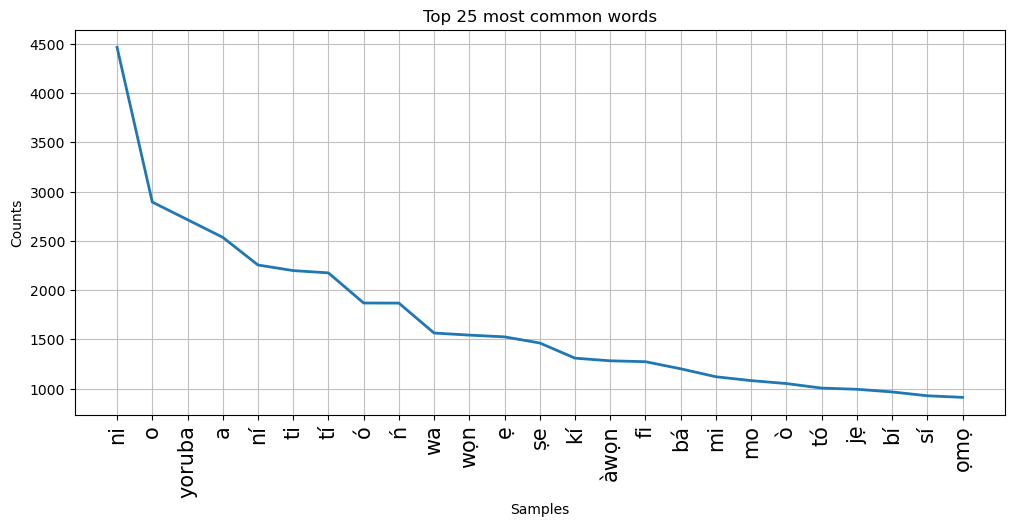

In [273]:
# visualize the most common words in the tweet column for the three languages
import nltk
all_words = []
for t in train_data['yoruba']['tweet']:
    all_words.extend(t.split())

print(all_words[:50])
len(set(all_words))

# Frequency Distribution
freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()


In [206]:
len(vectorizer.vocabulary_)

1642